# SECOM Classification

This Dataset is coming from the UCI machine learning repository.
It was generated by a semi-conductor manufacturing process.

https://archive.ics.uci.edu/ml/datasets/SECOM


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pycaret.classification import *

Data loading and preview 

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom_X = pd.read_csv(url, header=None, sep=' ')

#Adding a name to features
a = np.arange(1,secom_X.shape[1]+1)
b = ['x' + str(i) for i in np.arange(1,len(a)+1)]
secom_X.columns = b

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secom_y = pd.read_csv(url, header=None, delim_whitespace=True, usecols=[0], names=['target'], squeeze=True)

secom_X.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x581,x582,x583,x584,x585,x586,x587,x588,x589,x590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


## EDA and data preparation

Let's get to know this dataset

In [3]:
secom_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, x1 to x590
dtypes: float64(590)
memory usage: 7.1 MB


Checking the nulls and how many features are affected

In [4]:
print('Overall Null ratio in the dataframe: %.3f' % (secom_X.isnull().sum().sum() / secom_X.count().sum()))

Overall Null ratio in the dataframe: 0.048


[]

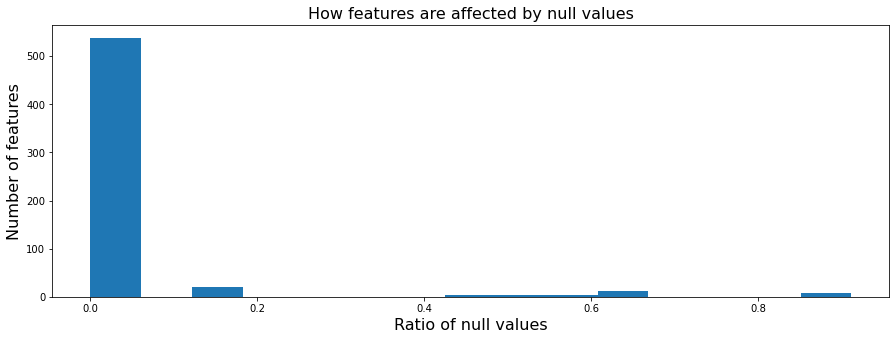

In [5]:
t = secom_X.isnull().sum()/secom_X.shape[0]
t= (t.sort_values(ascending= False))

plt.figure(figsize=(15,5))
plt.hist(t,bins= 15)
plt.ylabel("Number of features", fontsize=16) 
plt.xlabel("Ratio of null values", fontsize=16) 
plt.title("How features are affected by null values",fontsize=16) 
plt.plot()

Let's get rid of the features where there are more than 40% of null values.
A trial with a 15% of null threshold has shown that there is a significant loss of accuracy in the models

In [6]:
secom_X = secom_X.dropna(thresh=secom_X.shape[0]*0.6,how='all',axis=1)
secom_X.shape

(1567, 558)

Removing columns that are constant and imputing the median to null values.

Using KNNImputer didn't provide a significant improvement over the median imputation

In [7]:
sdf = pd.DataFrame(secom_X)

# Filling with the median
sdf.fillna(sdf.median(), inplace=True)

print('Number of constant columns:',len(sdf.columns[sdf.nunique()==1]))

#Keeping only the non constant columns
secom_X = sdf.loc[:,sdf.columns[sdf.nunique()>1]].copy().to_numpy()

Number of constant columns: 116


The target needs to be relabelled for PyCaret. (Move that below?)

In [8]:
secom_y[secom_y==-1] = '0'
secom_y[secom_y==1] = '1'

### Class imbalance

In [9]:
print('Number of rows for each class %s' % Counter(secom_y))

Number of rows for each class Counter({'0': 1463, '1': 104})


The two classes will be rebalanced using SMOTE (Synthetic Minority Oversampling Technique)

In [10]:
smote = SMOTE(sampling_strategy='all', random_state=0)
X_resampled, y_resampled = smote.fit_sample(secom_X, secom_y)

# count points per class
print('Number of rows for each class %s' % Counter(y_resampled))

Number of rows for each class Counter({'0': 1463, '1': 1463})


The data being now balanced, the dataset can be split

### Splitting the Dataset
20% of the dataset will be put aside for the final validation, while the rest will used as train/test for PyCaret.

In [11]:
# As the dataset is balanced, there is no need to stratify
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X_resampled,\
                                                                    y_resampled,train_size = 0.8,\
                                                                    random_state= 19)

Preparing both train/test and validation dataframes for Pycaret

In [12]:
# Train/test PyCaret dataframe
# Adding features and target to a new dataframe
data = pd.DataFrame(np.column_stack((X_train_test, y_train_test)))

# Naming features
a = np.arange(1,data.shape[1]+1)
b = ['x' + str(i) for i in np.arange(1,len(a)+1)]
data.columns = b

# Renaming the last columns as the target
data.rename(columns={data.columns[-1]:'target'},inplace = True)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x434,x435,x436,x437,x438,x439,x440,x441,x442,target
0,3073.67,2349.48,2244.11,1676.73,0.9197,100.807,0.1204,1.4596,0.0034,0.0057,...,7.1019,0.5018,0.0105,0.0032,2.0884,0.0135,0.0114,0.0043,84.4337,0
1,2940.5,2441.61,2205.29,1630.31,1.2733,98.8056,0.1218,1.358,-0.0024,-0.0143,...,16.8002,0.4981,0.0143,0.0038,2.876,0.0334,0.0206,0.0067,61.6014,0
2,3173.18,2428.64,2209.47,1556.39,1.4884,95.1156,0.1206,1.6073,-0.0278,-0.0057,...,12.2013,0.5021,0.0192,0.0041,3.8289,0.0281,0.0247,0.0075,88.1528,1
3,2924.96,2564.29,2171.86,940.992,1.2906,103.473,0.1234,1.3949,0.0084,-0.0031,...,16.2491,0.5027,0.0154,0.0031,3.0668,0.0252,0.0157,0.0046,62.3881,0
4,3178.34,2449.96,2213.38,1758.76,1.18861,96.51,0.124567,1.53899,0.00261546,-0.0171066,...,15.9599,0.502391,0.0169008,0.00360962,3.36646,0.0209466,0.00706607,0.00200936,32.9475,1


In [13]:
# Validation data

data_unseen = pd.DataFrame(np.column_stack((X_validation, y_validation)))

# Add Target to secom_x and rename
a = np.arange(1,data_unseen.shape[1]+1)
b = ['x' + str(i) for i in np.arange(1,len(a)+1)]
data_unseen.columns = b

data_unseen.rename(columns={data_unseen.columns[-1]:'target'},inplace = True)
data_unseen.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x434,x435,x436,x437,x438,x439,x440,x441,x442,target
0,2946.56,2444.87,2171.45,1209.2,1.31631,101.804,0.122184,1.56326,-0.00847947,0.00389983,...,24.2203,0.503145,0.0113549,0.00291626,2.25609,0.0285985,0.0162716,0.00535944,57.6576,1
1,3164,2437.64,2203.95,1555.06,1.39654,97.8247,0.123407,1.42604,-0.00552275,-0.011276,...,13.2098,0.500139,0.0117223,0.00297074,2.34056,0.0207765,0.0227847,0.00679211,116.18,1
2,2965.67,2606,2155.63,1070.04,0.8024,101.433,0.1241,1.4161,0.0209,-0.0095,...,23.6473,0.4976,0.0138,0.0035,2.7728,0.0048,0.0226,0.0079,474.081,0
3,2924.55,2485.62,2181.38,1244.86,1.32457,101.858,0.122346,1.51381,-0.0180096,-0.00489653,...,24.4716,0.501111,0.0144557,0.00363702,2.87866,0.015374,0.012595,0.00366756,85.1664,1
4,3072.31,2308.6,2176.63,1272.41,1.3828,100.462,0.1216,1.4378,-0.0282,0.0012,...,23.9171,0.5016,0.0196,0.0049,3.9151,0.0135,0.0114,0.0043,84.4337,0


Final check for both datasets

In [14]:
print('Train/test size: ' + str(data.shape[0]))
print('\tClass distribution %s' % Counter(data['target']))
print('Validation size: ' + str(data_unseen.shape[0]))
print('\tClass distribution %s' % Counter(data_unseen['target']))

Train/test size: 2340
	Class distribution Counter({'0': 1172, '1': 1168})
Validation size: 586
	Class distribution Counter({'1': 295, '0': 291})


## Modeling picking/tuning with Pycaret

#### Setup
- Data types had to be forced for all features. During the different trials, different features would be found as Categorical by PyCaret. 
- Data is normalized using the 'Robust' method
- Dimensionality reduction using PCA.

In [41]:
secom_mdl = setup(data = data, target = 'target' , numeric_features = data.columns[:-1],
                  normalize = True, normalize_method='robust', pca = True, pca_method = 
                  'linear', pca_components = 25,
                  feature_selection=False, feature_selection_threshold = 0.5, feature_interaction = False, 
                  feature_ratio = False, interaction_threshold = 0.01, 
                  session_id=123)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(2340, 443)"
4,Missing Values,False
5,Numeric Features,442
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### Comparing models

In [42]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extra Trees Classifier,0.940100,0.985100,0.942500,0.937900,0.940000,0.880300
1,CatBoost Classifier,0.920000,0.980000,0.953400,0.894500,0.922500,0.839900
2,Light Gradient Boosting Machine,0.915700,0.974200,0.949900,0.890100,0.918500,0.831500
3,Random Forest Classifier,0.857600,0.926200,0.824800,0.883500,0.851800,0.715200
4,Gradient Boosting Classifier,0.825900,0.908500,0.871400,0.799500,0.832800,0.651800
5,Extreme Gradient Boosting,0.819200,0.901300,0.864100,0.793800,0.826200,0.638400
6,K Neighbors Classifier,0.799600,0.908000,0.960800,0.727400,0.827600,0.599500
7,Decision Tree Classifier,0.779500,0.779600,0.806700,0.767700,0.785800,0.559100
8,Ada Boost Classifier,0.733000,0.815100,0.744000,0.726900,0.734100,0.466000
9,Logistic Regression,0.624200,0.687700,0.593200,0.628500,0.608500,0.248100


Let's pick the Extra Trees Classifier (https://www.geeksforgeeks.org/ml-extra-tree-classifier-for-feature-selection/)

Then use the create and tune that classifier.

In [43]:
type ='et'
dt = create_model(type)
tuned_model = tune_model(type)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9146,0.9627,0.9146,0.9146,0.9146,0.8293
1,0.9207,0.9738,0.9268,0.9157,0.9212,0.8415
2,0.9634,0.9934,0.9634,0.9634,0.9634,0.9268
3,0.9817,0.9990,0.9756,0.9877,0.9816,0.9634
4,0.9329,0.9847,0.9390,0.9277,0.9333,0.8659
5,0.9573,0.9958,0.9756,0.9412,0.9581,0.9146
6,0.9634,0.9936,0.9878,0.9419,0.9643,0.9268
7,0.9571,0.9935,0.9753,0.9405,0.9576,0.9141
8,0.9448,0.9813,0.9506,0.9390,0.9448,0.8896
9,0.9325,0.9828,0.9012,0.9605,0.9299,0.8650


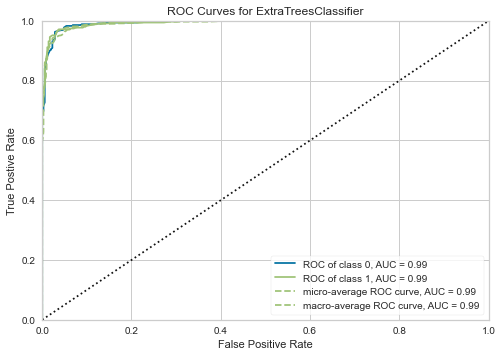

In [44]:
plot_model(tuned_model, plot = 'auc')

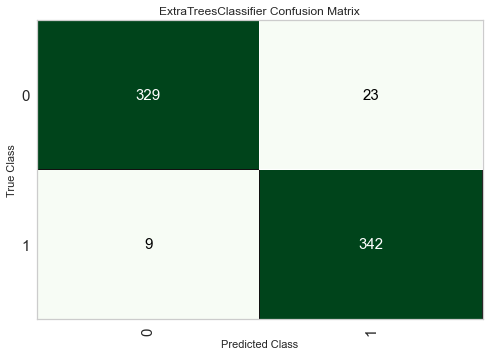

In [45]:
plot_model(tuned_model, plot = 'confusion_matrix')

## Model Validation with PyCaret

Making predictions using the unseen data

In [47]:
unseen_predictions = predict_model(tuned_model, data=data_unseen)

Printing the confusion matrix

In [48]:
unseen_predictions['Label'] = unseen_predictions['Label'].astype(str)
cm = confusion_matrix(unseen_predictions['target'], unseen_predictions['Label'])
print(cm)

[[265  26]
 [ 31 264]]


Final accuracy of the model

In [49]:
print('Accuracy Score: %.3f' % accuracy_score(unseen_predictions['target'],unseen_predictions['Label']))
print(classification_report(unseen_predictions['target'],unseen_predictions['Label']))

Accuracy Score: 0.903
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       291
           1       0.91      0.89      0.90       295

    accuracy                           0.90       586
   macro avg       0.90      0.90      0.90       586
weighted avg       0.90      0.90      0.90       586



The model is performing well with unseen data.

Next step: Feature selection should be used instead of PCA as in real life, the goal of such exercise might be to reduce test time on a factory line.